#Задание

Обучить сверточную нейронную сеть на PyTorch для распознавания китайских рукописных чисел(KMNIST).

https://www.kaggle.com/datasets/fedesoriano/chinese-mnist-digit-recognizer

#Загрузка датасета

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/chinese-mnist-digit-recognizer")

print("Path to dataset files:", path)

100%|██████████| 7.81M/7.81M [00:00<00:00, 10.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/chinese-mnist-digit-recognizer/versions/1


#Библиотеки

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as pp

In [ ]:
!pip install torchmetrics
import torchmetrics

In [ ]:
!pip freeze > requirements.txt

#Чтение датасета

In [3]:
data = pd.read_csv(f"{path}/chineseMNIST.csv")
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [4]:
data = data.drop('character', axis=1)
data['label'] = data['label'].replace({
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 10,
    100: 11,
    1000: 12,
    10000: 13,
    100000000: 14
})
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


#Разбиение датасета

In [5]:
# Количество исходных данных
print(len(data))

15000


In [6]:
data_train, validation_data, test_data = random_split(data, [12000, 1500, 1500])

Y_train= np.array([data['label'][i] for i in data_train.indices])
Y_valid = np.array([data['label'][i] for i in validation_data.indices])
Y_test = np.array([data['label'][i] for i in test_data.indices])
print(Y_train.shape, Y_valid.shape, Y_test.shape)

data = data.drop('label', axis=1)

X_train= np.array([data.iloc[i] for i in data_train.indices])
X_valid = np.array([data.iloc[i] for i in validation_data.indices])
X_test = np.array([data.iloc[i] for i in test_data.indices])
print(X_train.shape, X_valid.shape, X_test.shape)

(12000,) (1500,) (1500,)
(12000, 4096) (1500, 4096) (1500, 4096)


#Перегонка в tensor

In [7]:
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).reshape(-1, 1)
X_train_t = torch.tensor(X_train, dtype=torch.float32).reshape(-1,1,64,64)

Y_test_t = torch.tensor(Y_test, dtype=torch.float32).reshape(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32).reshape(-1,1,64,64)

Y_valid_t = torch.tensor(Y_valid, dtype=torch.float32).reshape(-1, 1)
X_valid_t = torch.tensor(X_valid, dtype=torch.float32).reshape(-1,1,64,64)

In [8]:
print(Y_train_t.shape, X_train_t.shape)
print(Y_test_t.shape, X_test_t.shape)
print(Y_valid_t.shape, X_valid_t.shape)

torch.Size([12000, 1]) torch.Size([12000, 1, 64, 64])
torch.Size([1500, 1]) torch.Size([1500, 1, 64, 64])
torch.Size([1500, 1]) torch.Size([1500, 1, 64, 64])


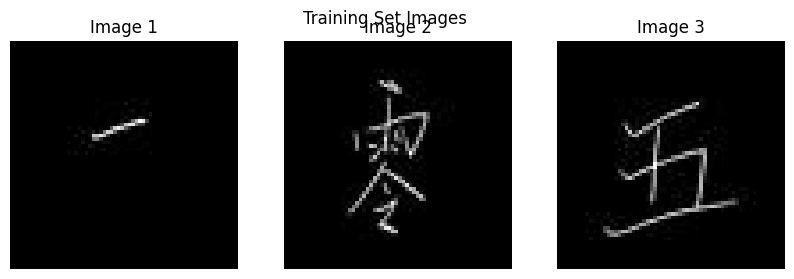

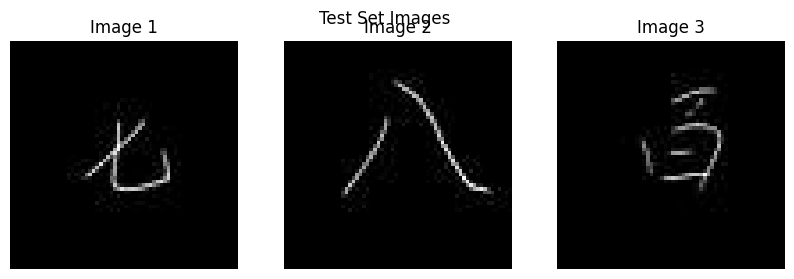

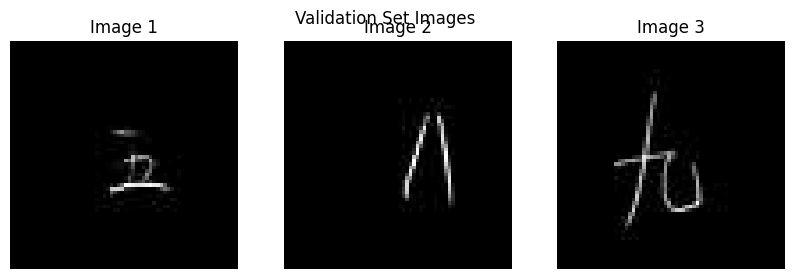

In [9]:
def display_images(dataset, title="Images"):
    pp.figure(figsize=(10, 3))  # Set the figure size
    for i in range(3):  # Display 3 images
        pp.subplot(1, 3, i+1)
        pp.imshow(dataset[i].reshape(64, 64), cmap='gray')  # Reshape to (64, 64) and plot in grayscale
        pp.axis('off')  # Hide axes
        pp.title(f"Image {i+1}")
    pp.suptitle(title)  # Add a title above the images
    pp.show()
# Display 3 images from each set
display_images(X_train, "Training Set Images")
display_images(X_test, "Test Set Images")
display_images(X_valid, "Validation Set Images")

#Создание модели

In [10]:
# Длина входного вектора = 4096
# Кол-во классов = 15

class KMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(in_channels=64,
                               out_channels=32,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.dp1 = nn.Dropout2d(0.2)

        self.conv3 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        self.dp2 = nn.Dropout2d(0.2)

        self.fl = nn.Flatten(start_dim=1, end_dim=-1)

        self.fc1 = nn.Linear(32*32*32, 1024)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.act5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(512)
        self.dp3 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 128)
        self.act6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(128)
        self.dp4 = nn.Dropout(0.5)

        self.solver = nn.Linear(128, 15)
        self.act_output=nn.Softmax()

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.act2(self.conv2(x))
        x = self.bn2(x)

        x = self.act3(self.conv3(x))
        x = self.bn3(x)

        x = self.fl(x)

        x = self.act4(self.fc1(x))
        x = self.bn4(x)

        x = self.act5(self.fc2(x))
        x = self.bn5(x)

        x = self.act6(self.fc3(x))
        x = self.bn6(x)

        x = self.act_output(self.solver(x))
        return x

    def call(self, x):
        #x = self.act_output(self.forward(x))
        x = self.forward(x)
        return x

model = KMNISTClassifier()
model

KMNISTClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout2d(p=0.2, inplace=False)
  (fl): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (act4): ReLU()
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, 

In [18]:
# Длина входного вектора = 4096
# Кол-во классов = 15

class KMNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*30*30, 128)  # 30*30 из вычислений размера после свертки и пулинга
        self.fc2 = nn.Linear(128, 15)
        self.act_output = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.act_output(self.fc2(x))
        return x

model = KMNISTClassifier()
model

KMNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
  (act_output): Softmax(dim=None)
)

In [ ]:
!pip install torchview

/usr/local/lib/python3.11/dist-packages/torch/overrides.py:1742: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = torch_func_method(public_api, types, args, kwargs)


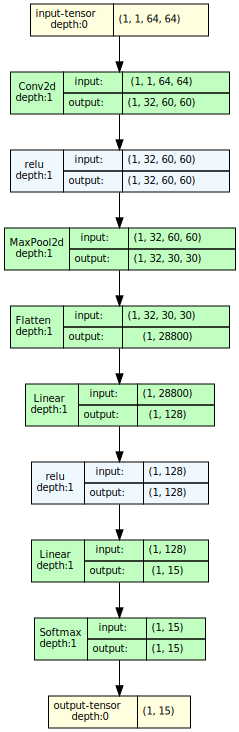

In [19]:
from torchview import draw_graph
model_graph = draw_graph(model, input_size=(1, 1, 64, 64), expand_nested=True)
model_graph.visual_graph

#Обучение модели

In [ ]:
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000
batch_size = 32
patience = 10
best_epoch, old_loss = 0, 1e100
lambda_reg = 1e-4

#torch.cuda.empty_cache()
X_valid_loader = torch.utils.data.DataLoader(X_valid_t, batch_size=32)
Y_valid_loader = torch.utils.data.DataLoader(Y_valid_t, batch_size=32)

for epoch in range(n_epochs):
    for i in range(0, len(X_train_t), batch_size):
        X_batch = X_train_t[i:i+batch_size]
        y_pred = model(X_batch.cuda())
        #y_pred = model(train_loader())
        y_batch = Y_train_t[i:i+batch_size]
        #y_batch = torch.argmax(y_batch, dim=1)
        loss = loss_fn(y_pred.cuda(), y_batch.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batch_n = 0
    loss = 0.0
    for x_valid_batch, y_valid_batch in zip(X_valid_loader, Y_valid_loader):
        Y_pred = model(x_valid_batch.cuda())
        out, inds = torch.max(Y_pred, dim=1)
        loss += loss_fn(y_valid_batch.cuda(), out)
        batch_n += 1
    #Y_pred = torch.argmax(Y_pred, dim=1).view(-1, 1).to(torch.float32)
    #max_probs, preds = torch.max(Y_pred, dim = 1)

    loss = loss / batch_n
    if loss < old_loss:
        best_epoch = epoch
        old_loss = loss
        best_model = model
    if epoch > best_epoch + patience:
        break

    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 6.15757942199707


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 22.12 MiB is free. Process 24846 has 14.72 GiB memory in use. Of the allocated memory 14.57 GiB is allocated by PyTorch, and 10.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

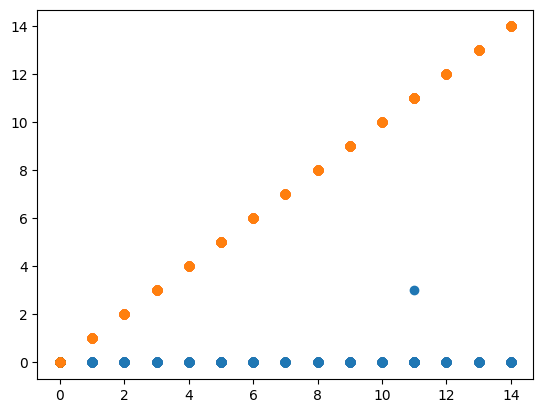

In [ ]:
Yp = best_model(X_test_t.cuda()).cpu().detach().numpy()
Ypc=np.argmax(Yp, axis=1)
pp.scatter(Y_test_t, Ypc)
pp.scatter(Y_test_t, Y_test_t)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test_t, Ypc))
print(classification_report(Y_test_t, Ypc))

[[ 90   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [102   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [102   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 99   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 94   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [117   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [100   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 82   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 94   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [105   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 92   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [128   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [ 94   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 97   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [103   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
              precision    recall  f1-score   support


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
